<a href="https://colab.research.google.com/github/ktichola/Image-matching/blob/main/ImageMatching2024_SuperGlue_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-matching-challenge-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F71885%2F8143495%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T164858Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1ae6c5284bcfcf5b2907b98c525187f15a3500a1f9e6d75c3e38296a3cac112f97c26b4d0ac5a223bc4b9c95ef5ea12e78e78707d043f0e022ba23e9d51e9a10470eb2f821b9c3fa4480cfdb5829151998aeaa0c75e117f3c45661e3929bcd8d9b9e61abeab40069f337c7157983f31ad77f62851d97b74de5ff8f6182cec2894050fe5cc7e41b1f180efbd28409f27625f9c3231252c2f34a9410e5c58a9596eb62769e3ce1925328cf74be49656ff9ac338914bcbf7ab362e76641a0700ae65180efe1a80fe8e6b513e99228f638252876f8315a0cc653a808cf9aa585b62638529fdff15b6a845c868791607b0ea34ae762d9deb4ff6e3dec7fb10f4c7cea,super-glue-pretrained-network:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2058261%2F3414836%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T164858Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da058cf6c1f897ec7889797280b869a3b773a249b5ac4a30e4342f97752bbddf735b5190d0fd5b561fe8649b782f134cc68e9104a6e03c8d0850a49d0640a5351d2084b95b255f4e91e4ff4690493cf35b5b751f920c0e97a2520d4822aa632b03d5137a5391d789cfba4425bb77f0d6bc7fa20d286f844ecbe6fe26cdd61bf36c2830c39cb3427f2e75363195280e3cafe484d8050113de5d2f5fc3d56c41563ae9885d2452fbd10547d540974abcfeed396e0d8f677819ba443b5209da63a566315bbf38caa0bc317718e9c4d7b23d94a8a5ff43f82bd1fbfe39807d3dca563bbf770871b3b5ee1f3a7500892e732435d8636296a7f16d955e66d0a61c9057b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
from PIL import Image, ImageDraw
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import cv2
import matplotlib

import kornia
import kornia as K
import kornia.feature as KF

#---------------
# For SuperGlue
import sys
sys.path.append("../input/super-glue-pretrained-network")
from models.matching import Matching
from models.utils import (compute_pose_error, compute_epipolar_error,
                          estimate_pose, make_matching_plot,
                          error_colormap, AverageTimer, pose_auc, read_image,
                          process_resize, frame2tensor,
                          rotate_intrinsics, rotate_pose_inplane,
                          scale_intrinsics)

from torch.nn import functional as torchF  # For resizing tensor

# SuperGlue model
https://github.com/magicleap/SuperGluePretrainedNetwork?tab=readme-ov-file
![superglue](https://github.com/magicleap/SuperGluePretrainedNetwork/blob/master/assets/teaser.png?raw=true)

In [ ]:
sg_config = {
    "superpoint": {
        "nms_radius": 4,
        "keypoint_threshold": 0.005,
        "max_keypoints": 2048
    },
    "superglue": {
        "weights": "outdoor",
        "sinkhorn_iterations": 10,
        "match_threshold": 0.2,
    }
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

matcher = Matching(sg_config).eval().to(device)

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


# Demo

In [ ]:
file1 = "/kaggle/input/image-matching-challenge-2024/test/church/images/00001.png"
file2 = "/kaggle/input/image-matching-challenge-2024/test/church/images/00006.png"

In [ ]:
def f_preprocess(image, device, resize, rotation, resize_float, w_new=None, h_new=None):
    w, h = image.shape[1], image.shape[0]
    w_new, h_new = process_resize(w, h, resize)

    scales = (float(w) / float(w_new), float(h) / float(h_new))

    if resize_float:
        image = cv2.resize(image.astype('float32'), (w_new, h_new))
    else:
        image = cv2.resize(image, (w_new, h_new)).astype('float32')

    inp = frame2tensor(image, device)
    return image, inp, scales, (h, w)

def get_mkpts_superglue(matcher, file1, file2, device=torch.device('cuda'), resize=[512,], resize_float=True):
    image1 = cv2.imread(file1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(file2, cv2.IMREAD_GRAYSCALE)

    _image_1, inp_1, scales_1, ori_shape_1 = f_preprocess(image1, device, resize, 0, resize_float)
    _image_2, inp_2, scales_2, ori_shape_2 = f_preprocess(image2, device, resize, 0, resize_float)
    image1 = torchF.interpolate(inp_1, (_image_1.shape[0], _image_1.shape[1]), mode='bilinear', align_corners=False)
    image2 = torchF.interpolate(inp_2, (_image_2.shape[0], _image_2.shape[1]), mode='bilinear', align_corners=False)

    pred = matcher({"image0": image1.to(device), "image1": image2.to(device)})
    pred = {k: v[0].detach().cpu().numpy().copy() for k, v in pred.items()}
    mkpts0, mkpts1 = pred["keypoints0"], pred["keypoints1"]
    matches, conf = pred["matches0"], pred["matching_scores0"]

    valid = matches > -1
    mkpts0 = mkpts0[valid]
    mkpts1 = mkpts1[matches[valid]]
    mconf = conf[valid]

    # Scaling coords
    mkpts0[:,0] = mkpts0[:,0] * ori_shape_1[1] / image1.shape[3]   # X
    mkpts0[:,1] = mkpts0[:,1] * ori_shape_1[0] / image1.shape[2]   # Y
    mkpts1[:,0] = mkpts1[:,0] * ori_shape_2[1] / image2.shape[3]   # X
    mkpts1[:,1] = mkpts1[:,1] * ori_shape_2[0] / image2.shape[2]   # Y
    return mkpts0, mkpts1, mconf

In [ ]:
%%time
mkpts1, mkpts2, mconf = get_mkpts_superglue(matcher, file1, file2)
print(mkpts1.shape, mkpts2.shape, mconf.shape)

(163, 2) (163, 2) (163,)
CPU times: user 670 ms, sys: 219 ms, total: 889 ms
Wall time: 1.51 s


# Viewer

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def veiw_keypoints(file1, file2, mkpts1, mkpts2, mconf, cmap_name="rainbow", height=480, drops=5):
    cmap = matplotlib.cm.get_cmap(cmap_name)
    img1 = Image.open(file1)
    img2 = Image.open(file2)

    w1, h1 = img1.size
    w2, h2 = img2.size

    h = height # max(h1, h2)
    ratio1 = h / h1
    ratio2 = h / h2

    _w1 = int(w1 * ratio1)
    _w2 = int(w2 * ratio2)

    mkpts1 = mkpts1 * ratio1
    mkpts2 = mkpts2 * ratio2
    mkpts2[:, 0] = mkpts2[:, 0] + _w1

    overlay = get_concat_h(img1.resize((_w1, h)), img2.resize((_w2, h)))

    display(overlay)

    draw = ImageDraw.Draw(overlay)
    for i in range(0, mkpts1.shape[0], drops):
        color = tuple((cmap([mconf[i]])[:, :3] * 255).astype(np.uint8)[0, :])
        draw.line((mkpts1[i, 0], mkpts1[i, 1], mkpts2[i, 0], mkpts2[i, 1]), fill=color, width=2)
    display(overlay)

file1, file2 :  /kaggle/input/image-matching-challenge-2024/test/church/images/00001.png /kaggle/input/image-matching-challenge-2024/test/church/images/00006.png


/tmp/ipykernel_34/4213382598.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap_name)


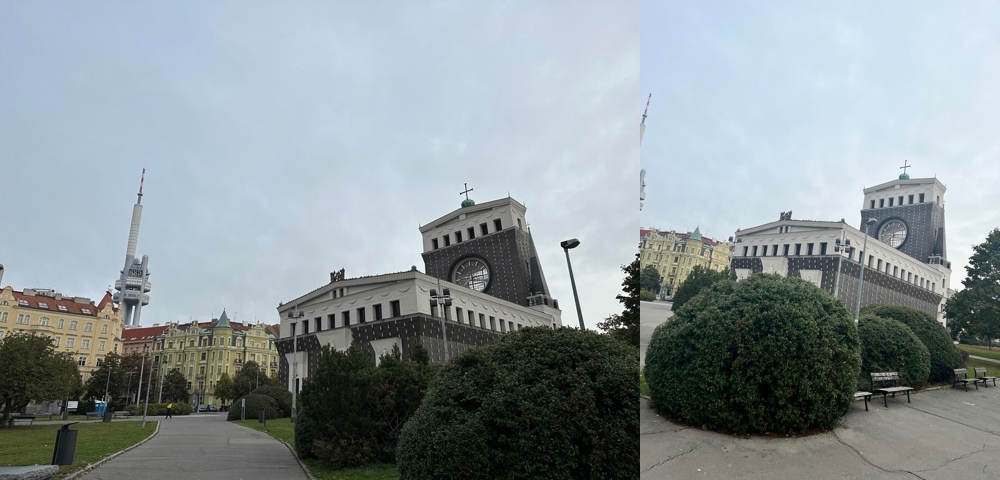

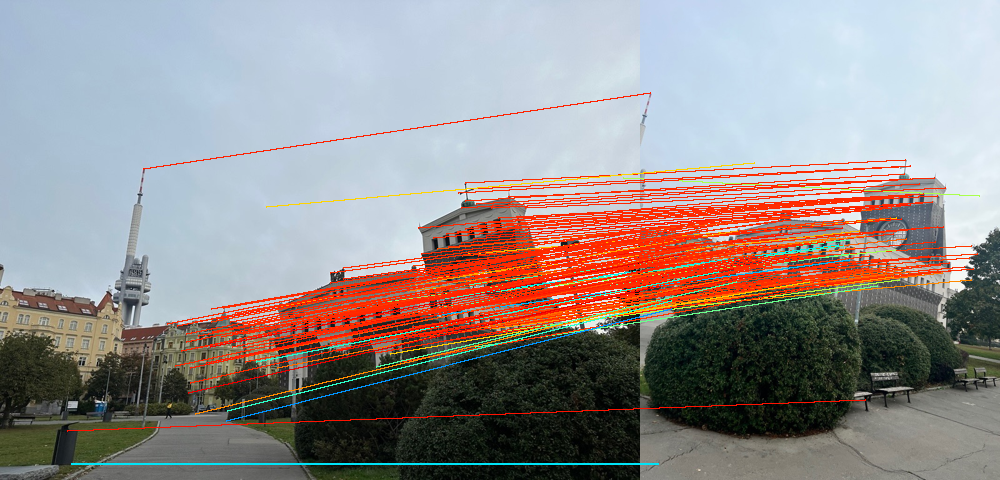

In [ ]:
print(f"file1, file2 : ", file1, file2)
veiw_keypoints(file1, file2, mkpts1, mkpts2, mconf, cmap_name="jet", height=480, drops=1)

# Fundamental matrix
ref: https://slideplayer.com/slide/5279455/  
![fmatrix](https://slideplayer.com/slide/5279455/17/images/4/Fundamental+matrix+epipolar+plane.+epipolar+line.+epipolar+line.+%28projection+of+ray%29+Image+1.+Image+2..jpg)

In [ ]:
import cv2

In [ ]:
# calc Fundamental matrix from keypoints
F, inliers = cv2.findFundamentalMat(mkpts1, mkpts2, cv2.USAC_MAGSAC, 0.200, 0.9999, 30000)
inliers = inliers > 0
sampled_mkpts1 = mkpts1[inliers[:,0]]
sampled_mkpts2 = mkpts2[inliers[:,0]]
sampled_mconf  = mconf[inliers[:,0]]

print(f"F.shape = ", F.shape)
print(f"F = ", F)
print("keypoints :", mkpts1.shape, "-->", sampled_mkpts1.shape)

F.shape =  (3, 3)
F =  [[-1.33339732e-06 -7.80115075e-06  4.71993425e-03]
 [ 8.32437109e-06 -4.91035975e-07  2.40102652e-04]
 [-4.80506095e-03 -1.85811167e-03  1.15462905e+00]]
keypoints : (163, 2) --> (20, 2)


/tmp/ipykernel_34/4213382598.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap_name)


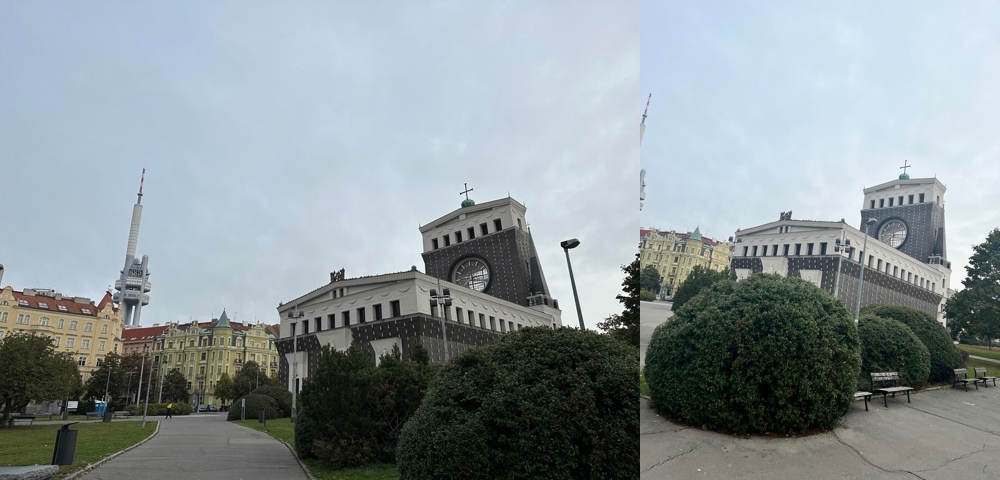

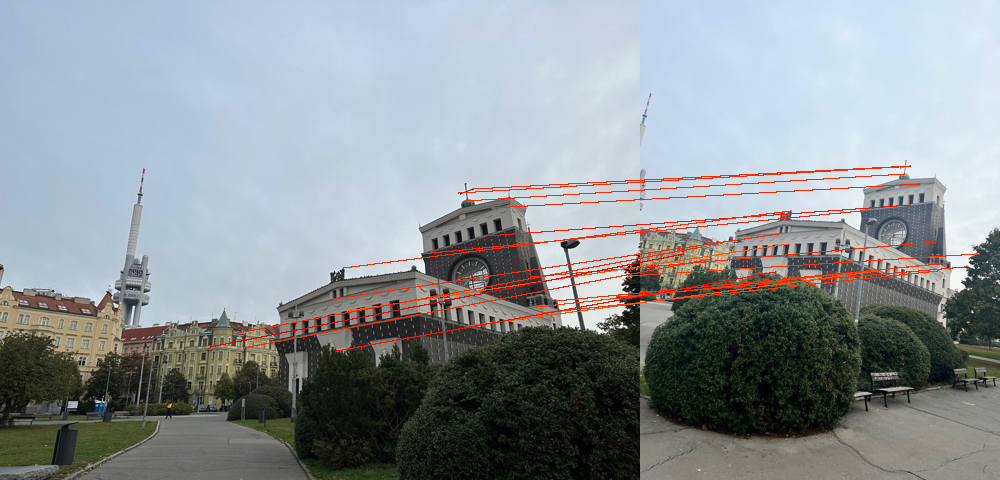

In [ ]:
veiw_keypoints(file1, file2, sampled_mkpts1, sampled_mkpts2, sampled_mconf, cmap_name="jet", height=480, drops=1)